In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [4]:
print(train_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [7]:
print(test_data.data.size())

torch.Size([10000, 28, 28])


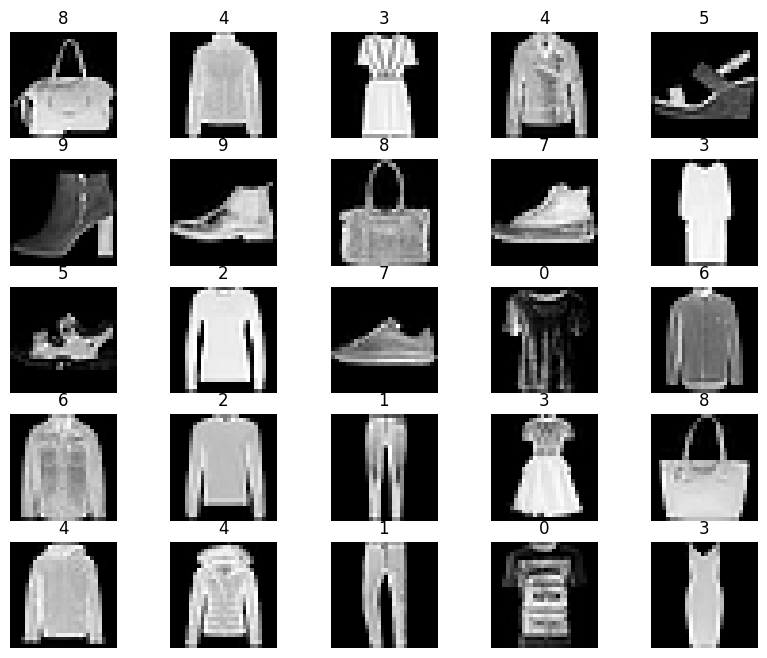

In [8]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f30ad42ed50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f30ad9c15d0>}

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,64,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            nn.Conv2d(128,64,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )
        self.classification_head=nn.Sequential(nn.Linear(64,20,bias=True),
                                               nn.ReLU(),
                                               nn.Linear(20,10,bias=True))
    def forward(self,x):
        features = self.net(x)
        return self.classification_head(features.view(100,-1))
            
        

In [11]:
cnn = CNN().to(device)

In [12]:
print(cnn)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_head): Sequential(
    (0): Linear(in_features=64, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [13]:
loss_func = nn.CrossEntropyLoss().to(device)

In [14]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [15]:
sum(p.numel() for p in cnn.parameters())

149798

In [16]:
losses = []
epoch = 0
for batch,labels in loaders['train']:
    epoch+=1
    batch = batch.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    loss = loss_func(cnn(batch),labels)
    losses.append(loss.item())
    print(loss.item())
    loss.backward()
    optimizer.step()
    if epoch ==2:
        break
    

/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


2.3239095211029053
2.4912753105163574


In [17]:
print("Models state dict :")
for param_tensor in cnn.state_dict().keys():
    print(param_tensor,'\t',cnn.state_dict()[param_tensor])

Models state dict :
net.0.weight 	 tensor([[[[-1.1146e-01, -7.9141e-02, -3.1854e-01],
          [-1.1569e-01,  1.7571e-01, -9.2985e-02],
          [-2.4858e-01, -5.9234e-02, -7.6263e-02]]],


        [[[ 2.7036e-01, -2.7835e-01, -2.3952e-01],
          [-2.8279e-01, -2.5013e-01,  6.2314e-02],
          [ 4.0178e-02,  2.6713e-01, -3.1327e-01]]],


        [[[-2.6564e-01,  1.3677e-01,  2.0803e-01],
          [ 2.8802e-01, -2.3264e-01,  8.9972e-02],
          [ 2.8114e-01,  1.1075e-01,  2.7656e-01]]],


        [[[-1.2568e-01, -2.3015e-01, -8.5579e-02],
          [-2.3282e-01,  2.2477e-01, -1.0102e-01],
          [ 1.3323e-02,  2.7078e-01, -4.1432e-02]]],


        [[[ 3.3331e-03, -1.6597e-01, -6.7068e-02],
          [ 9.2591e-02, -1.8994e-01, -1.2986e-01],
          [ 1.2201e-01,  2.7472e-01, -3.0036e-01]]],


        [[[ 1.7568e-01,  1.9265e-01,  1.4012e-01],
          [ 1.1785e-01,  4.2022e-02,  1.7357e-01],
          [-7.6878e-02,  1.8076e-01,  1.8331e-01]]],


        [[[-1.7375e-01,

In [18]:
print("Optimizer state dict :")
for param_tensor in optimizer.state_dict().keys():
    print(param_tensor,'\t',optimizer.state_dict()[param_tensor])

Optimizer state dict :
state 	 {0: {'step': tensor(2.), 'exp_avg': tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],


        [[[-5.7432e-05, -1.6856e-05, -2.5624e-05],
          [-5.2686e-05, -3.9471e-05, -6.3410e-05],
          [-9.3787e-05, -1.3982e-04, -9.6558e-05]]],


        [[[ 1.5834e-03,  1.8939e-03,  2.1555e-03],
          [ 2.0992e-03,  1.8776e-03,  2.1677e-03],
          [ 2.2546e-03,  2.1467e-03,  2.3907e-03]]],


        [[[ 1.6177e-04,  3.2026e-04,  3.7056e-04],
          [ 1.8412e-04,  4.6254e-04,  4.2621e-04],
          [ 2.8048e-04,  5.3877e-04,  4.4564e-04]]],


        [[[ 1.2218e-05,  2.7629e-06, -1.8789e-06],
          [ 2.2983e-05,  5.4075e-06,  9.8045e-07],
          [ 2.8183e-05,  1.7261e-05,  1.2867e-06]]],


        [[[ 1.8142e-03,  1.9307e-03,  1.9195e-03],
          [ 1.8454e-03,  1.9436e-03,  2.0331e-03],
          [ 1.6967e-03,  1.9602e-03,  2.0647e-

In [19]:
check_point = {'last_loss' : losses[-1],"last_epoch":epoch,"model_state":cnn.state_dict(),"optimizer_state":optimizer.state_dict()}
torch.save(check_point,"./checkpoints/checkpoint.pt")

In [20]:
checkpoint = torch.load("./checkpoints/checkpoint.pt")
model = CNN().to(device)
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [21]:
model.eval()

CNN(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_head): Sequential(
    (0): Linear(in_features=64, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [22]:
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)  

In [23]:
optimizer.load_state_dict(checkpoint['optimizer_state'])

In [24]:
loss = checkpoint['last_loss']
last_epoch = checkpoint['last_epoch']

In [25]:
last_epoch

2

In [26]:
epochs = 0
losses = []
for batch,labels in loaders['train']:
    batch = batch.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    loss = loss_func(model(batch),labels)
    print(loss)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

tensor(2.3969, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2956, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2887, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2214, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1344, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9997, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8192, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8920, device='cuda:0', grad_fn=